# **Comparing Implied Volatility and Market Downturns using BS & Logistic Regression**



## **Introduction**:

* Research Question: What factors contribute to the presence and magnitude of the volatility smirk in equity options, and how do their dynamics correlate
with events and annualized volatility across different market sectors (ie: tech - high volatility vs. utilities - low volatility)? Specifically, do abrupt changes, like a sudden steepening in the IV smirk, reliably forecast short-term market declines or volatility spikes beyond standard risk measures (VIX)?

We hypothesize that abrupt changes in the implied volatility smirk, characterized as significant increases between the out-of-the-money put & the at-the-money call implied volatilities, predict a higher probability of short-term market downturns. Furthermore, the shift captures the investor sentiment and jump risk not fully reflected by historical volatility or the VIX, thereby offering superior early-warning capabilities.



# **Data & Pre-Processing**

### Dataset Overview
This analysis uses **daily put and call options data** for the Invesco QQQ ETF (Nasdaq: QQQ) from Q1 2020 to Q4 2022. The QQQ tracks the Nasdaq-100 Index, which is heavily weighted toward technology stocks. This period was chosen due to its extreme volatility, including:
- The COVID-19 market crash (Q1 2020)
- The tech-driven recovery (2021)
- The 2022 bear market driven by rising interest rates.

The dataset includes:
- **Option metrics**: Implied volatility (IV), delta, bid/ask prices, volume, and strike details.
- **Underlying asset data**: Daily closing prices for QQQ.
- **Time-to-expiration**: Days until contract expiry (`DTE`).

### Preprocessing Steps
1. **Column Standardization**:  
   Column names were cleaned (whitespace removed) and renamed for consistency.  
   Example: `[QUOTE_DATE]` → `QUOTE_DATE`.

2. **Data Type Conversion**:  
   - Dates (`QUOTE_DATE`, `EXPIRE_DATE`) converted to `datetime`.  
   - Numeric fields (e.g., `C_BID`, `P_IV`) coerced to floats, handling invalid entries.  

3. **Time-to-Expiration Calculation**:  
   Computed as:  
   $$
   \text{DTE} = \text{EXPIRE_DATE} - \text{QUOTE_DATE}
   $$

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# Mount Google Drive and load data
from google.colab import drive
drive.mount('/content/drive')

filepath = '/content/drive/MyDrive/Colab Notebooks/qqq_2020_2022.csv'
df = pd.read_csv(filepath)

# Data Cleaning and Preparation
# First clean all column names by stripping whitespace
df.columns = df.columns.str.strip()

# Create comprehensive rename dictionary for ALL columns
full_rename_dict = {
    '[QUOTE_UNIXTIME]': 'QUOTE_UNIXTIME',
    '[QUOTE_READTIME]': 'QUOTE_READTIME',
    '[QUOTE_DATE]': 'QUOTE_DATE',
    '[QUOTE_TIME_HOURS]': 'QUOTE_TIME_HOURS',
    '[UNDERLYING_LAST]': 'UNDERLYING_LAST',
    '[EXPIRE_DATE]': 'EXPIRE_DATE',
    '[EXPIRE_UNIX]': 'EXPIRE_UNIX',
    '[DTE]': 'DTE',
    '[C_DELTA]': 'C_DELTA',
    '[C_GAMMA]': 'C_GAMMA',
    '[C_VEGA]': 'C_VEGA',
    '[C_THETA]': 'C_THETA',
    '[C_RHO]': 'C_RHO',
    '[C_IV]': 'C_IV',
    '[C_VOLUME]': 'C_VOLUME',
    '[C_LAST]': 'C_LAST',
    '[C_SIZE]': 'C_SIZE',
    '[C_BID]': 'C_BID',
    '[C_ASK]': 'C_ASK',
    '[STRIKE]': 'STRIKE',
    '[P_BID]': 'P_BID',
    '[P_ASK]': 'P_ASK',
    '[P_SIZE]': 'P_SIZE',
    '[P_LAST]': 'P_LAST',
    '[P_DELTA]': 'P_DELTA',
    '[P_GAMMA]': 'P_GAMMA',
    '[P_VEGA]': 'P_VEGA',
    '[P_THETA]': 'P_THETA',
    '[P_RHO]': 'P_RHO',
    '[P_IV]': 'P_IV',
    '[P_VOLUME]': 'P_VOLUME',
    '[STRIKE_DISTANCE]': 'STRIKE_DISTANCE',
    '[STRIKE_DISTANCE_PCT]': 'STRIKE_DISTANCE_PCT'
}

# Apply rename in one operation
df = df.rename(columns=full_rename_dict)

# Verify columns exist
assert 'STRIKE_DISTANCE_PCT' in df.columns
print("All required columns present:", list(df.columns))

# Convert and calculate necessary fields
df['QUOTE_DATE'] = pd.to_datetime(df['QUOTE_DATE'])
df['EXPIRE_DATE'] = pd.to_datetime(df['EXPIRE_DATE'])
numeric_cols = ['C_BID', 'C_ASK', 'P_BID', 'P_ASK', 'C_IV', 'P_IV', 'C_DELTA', 'P_DELTA']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['DTE'] = (df['EXPIRE_DATE'] - df['QUOTE_DATE']).dt.days
print(df['DTE'])

Mounted at /content/drive


<ipython-input-1-058d80be8275>:15: DtypeWarning: Columns (15,17,18,20,21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


All required columns present: ['QUOTE_UNIXTIME', 'QUOTE_READTIME', 'QUOTE_DATE', 'QUOTE_TIME_HOURS', 'UNDERLYING_LAST', 'EXPIRE_DATE', 'EXPIRE_UNIX', 'DTE', 'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_IV', 'C_VOLUME', 'C_LAST', 'C_SIZE', 'C_BID', 'C_ASK', 'STRIKE', 'P_BID', 'P_ASK', 'P_SIZE', 'P_LAST', 'P_DELTA', 'P_GAMMA', 'P_VEGA', 'P_THETA', 'P_RHO', 'P_IV', 'P_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT']
0            4
1            4
2            4
3            4
4            4
          ... 
1775744    836
1775745    836
1775746    836
1775747    836
1775748    836
Name: DTE, Length: 1775749, dtype: int64


# Enhanced Skew Calculation

### Methodology
We adopt a **delta-based skew decomposition** inspired by Doran & Krieger (2010), extending it to capture the full volatility smile:

**Put Skew Measures**:  
   - **Deep OTM puts**: $$(\Delta \leq -0.25)$$
   - **OTM puts**: $$(-0.25 < \Delta \leq -0.15)$$
   - **ATM puts**: $$(-0.15 < \Delta \leq -0.05)$$  

   Differences in implied volatility (IV) between these groups:  
   $$
   \Delta s_{Pdo,o} = s_{Pdo} - s_{Po} \quad \text{(slope of put skew)}
   $$
   $$
   \Delta s_{Pdo,a} = s_{Pdo} - s_{Pa} \quad \text{(curvature of put skew)}
   $$


In [ ]:
# Enhanced Skew Calculation
def calculate_skew_measures(group):
    put_cond = group['P_DELTA'] < 0
    s_Pdo = group[put_cond & (group['P_DELTA'] <= -0.25)]['P_IV'].mean()
    s_Po = group[put_cond & (group['P_DELTA'] > -0.25) & (group['P_DELTA'] <= -0.15)]['P_IV'].mean()
    s_Pa = group[put_cond & (group['P_DELTA'] > -0.15) & (group['P_DELTA'] <= -0.05)]['P_IV'].mean()

    call_cond = group['C_DELTA'] > 0
    s_Cdo = group[call_cond & (group['C_DELTA'] >= 0.25)]['C_IV'].mean()
    s_Co = group[call_cond & (group['C_DELTA'] >= 0.15) & (group['C_DELTA'] <= 0.25)]['C_IV'].mean()

    return pd.Series({
        'Δs_Pdo_o': s_Pdo - s_Po,
        'Δs_Pdo_a': s_Pdo - s_Pa,
        'Δs_Cdo_o': s_Cdo - s_Co,
        'ATM_IV': group[(group['STRIKE_DISTANCE_PCT'] <= 0.05)]['P_IV'].mean(),
        'BidAsk_Spread': (group['P_ASK'] - group['P_BID']).mean(),
        'Volume': group['P_VOLUME'].sum(),
        'DTE': group['DTE'].iloc[0]  # Include DTE
    })

skew_df = df.groupby(['QUOTE_DATE', 'EXPIRE_DATE']).apply(calculate_skew_measures).reset_index()

<ipython-input-2-62651c9188f7>:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  skew_df = df.groupby(['QUOTE_DATE', 'EXPIRE_DATE']).apply(calculate_skew_measures).reset_index()


# Market Data Prep & Lee-Mykland Jump Detection

### Jump Detection Methodology
We use the **Lee-Mykland (2008) nonparametric jump detection framework**, which identifies jumps by standardizing returns against local volatility:

1. **Local Volatility Estimate**:  
   Rolling 30-day standard deviation:  
   $$
   \hat{\sigma}_t = \text{std}(\log(S_{t-29:t}))
   $$

2. **Test Statistic**:  
   $$
   T(t) = \frac{\log(S_t) - \log(S_{t-1})}{\hat{\sigma}_{t-1}}
   $$

3. **Jump Threshold**:  
   A return is flagged as a jump if:  
   $$
   T(t) < -3.0 \quad \text{(99.7% confidence under normality)}
   $$

### Code Implementation
```python
def detect_jumps(returns, window=30, critical=3.0):
    local_vol = returns.rolling(window).std()
    T_stats = returns / local_vol.shift(1)
    return (T_stats < -critical).astype(int)
```

### Advantages Over Fixed Thresholds
- **Adjusts for volatility regimes**: A -3% return in a low-volatility market is treated differently than in a high-volatility market.
- **Reduces false positives**: Only extreme moves relative to recent volatility are flagged.

---


In [ ]:
# Market Data Preparation
market_df = df.groupby('QUOTE_DATE')['UNDERLYING_LAST'].last().reset_index()
market_df.columns = ['Date', 'Close']
market_df['log_ret'] = np.log(market_df['Close']/market_df['Close'].shift(1))

# Lee-Mykland Jump Detection
def detect_jumps(returns, window=30, critical=3.0):
    local_vol = returns.rolling(window).std()
    T_stats = returns / local_vol.shift(1)
    return (T_stats < -critical).astype(int)

market_df['Jump'] = detect_jumps(market_df['log_ret'])
market_df['Date'] = pd.to_datetime(market_df['Date'])

# Merge Datasets
skew_df['QUOTE_DATE'] = pd.to_datetime(skew_df['QUOTE_DATE'])
merged_data = pd.merge_asof(
    market_df.sort_values('Date'),
    skew_df.sort_values('QUOTE_DATE'),
    left_on='Date',
    right_on='QUOTE_DATE',
    direction='backward'
)

merged_data['DTE'] = (merged_data['EXPIRE_DATE'] - merged_data['QUOTE_DATE']).dt.days  # Optional safeguard



# Feature Engineering & Adjustments

### Key Features
1. **Maturity Binning**:  
   Options grouped into expiration cohorts:  
   ```python
   merged_data['MaturityBin'] = pd.cut(..., bins=[10, 30, 60, 90])
   ```  
   Rationale: Skew dynamics differ for near- vs. long-dated options.

2. **Controls**:  
   - **ATM IV**: Controls for overall market volatility (Bollen & Whaley, 2004).  
   - **Bid-Ask Spread**: Proxy for liquidity conditions.  
   - **Volume**: Captures speculative activity (Cremers & Weinbaum, 2010).

### Class Imbalance Adjustment
Jumps are rare events (<5% of observations). We upsample the minority class:  
```python
minority_upsampled = resample(minority, n_samples=len(majority))
```

---

In [ ]:
# Feature Engineering
merged_data['MaturityBin'] = pd.cut(merged_data['DTE'],
                                   bins=[10, 30, 60, 90],
                                   labels=['10-30d', '31-60d', '61-90d'])

# Final DataFrame Preparation
model_df = merged_data[['Jump', 'Δs_Pdo_o', 'Δs_Pdo_a', 'Δs_Cdo_o',
                       'ATM_IV', 'BidAsk_Spread', 'Volume']].dropna()

# Handle Class Imbalance
majority = model_df[model_df.Jump == 0]
minority = model_df[model_df.Jump == 1]
minority_upsampled = resample(minority,
                             replace=True,
                             n_samples=len(majority),
                             random_state=42)
balanced_df = pd.concat([majority, minority_upsampled])

# Logistic Regression

***Note For Regression Analysis: Because of the model we imported in, variable coefficient numbering is reverse sorted in the actual model, and x4 represents 'Δs_Pdo_o'/'Δs_Pdo_a' in regression, while x1 is 'Volume***'


### Model Specification
#### Regression 1 - Put Skew Slope:
$$
\text{Prob(Jump)} = \Phi\left( \beta_0 + \beta_1 \Delta s_{Pdo,o}  + \beta_2 \text{ATM IV} + \beta_3 \text{BidAsk} + \beta_4 \text{Volume} \right)
$$
#### Regression 2 - Put Skew Curvature:
$$
\text{Prob(Jump)} = \Phi\left( \beta_0 + \beta_1 \Delta s_{Pdo,a} + \beta_2 \text{ATM IV} + \beta_3 \text{BidAsk} + \beta_4 \text{Volume} \right)
$$

### Diagnostics
#### Regression 1 - Put Skew Slope:
- **Pseudo \(R^2\)**: 0.3332 (moderate explanatory power).  

#### Regression 2 - Put Skew Curvature:
- **Pseudo \(R^2\)**: 0.3467 (moderate explanatory power).  


In [ ]:
# Logistic Regression 1 on Put Skew Slope - 'Δs_Pdo_o'
X1 = balanced_df[['Δs_Pdo_o',
                'ATM_IV', 'BidAsk_Spread', 'Volume']] # Because of the model we imported in, x4 represents 'Δs_Pdo_o'/'Δs_Pdo_a' in regression, x1 is 'Volume'
y1 = balanced_df['Jump']

# Convert Volume column to summed numeric values
balanced_df['Volume'] = (
    balanced_df['Volume']
    .astype(str)  # Ensure we're working with strings
    .apply(lambda x: sum(pd.to_numeric(x.split(), errors='coerce')))
    .fillna(0)  # Handle cases with invalid/non-numeric values
)


scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X1)
X1_scaled = sm.add_constant(X1_scaled)

model1 = sm.Logit(y1, X1_scaled).fit()
print("Logistic Regression on Put Skew Slope - 'Δs_Pdo_o'")
print(model1.summary())

# Diagnostic Checks
vif = pd.DataFrame()
vif["Variable"] = ['const'] + X1.columns.tolist()
vif["VIF"] = [variance_inflation_factor(X1_scaled, i) for i in range(X1_scaled.shape[1])]
print("\nVariance Inflation Factors:")
print(vif)

# Logistic Regression 2 on Put Skew Curvature - 'Δs_Pdo_a'
X2 = balanced_df[['Δs_Pdo_a',
                'ATM_IV', 'BidAsk_Spread', 'Volume']]
y2 = balanced_df['Jump']

# Convert Volume column to summed numeric values
balanced_df['Volume'] = (
    balanced_df['Volume']
    .astype(str)  # Ensure we're working with strings
    .apply(lambda x: sum(pd.to_numeric(x.split(), errors='coerce')))
    .fillna(0)  # Handle cases with invalid/non-numeric values
)


scaler = StandardScaler()
X2_scaled = scaler.fit_transform(X2)
X2_scaled = sm.add_constant(X2_scaled)

model2 = sm.Logit(y2, X2_scaled).fit()
print(model2.summary())

# Diagnostic Checks
vif = pd.DataFrame()
vif["Variable"] = ['const'] + X2.columns.tolist()
vif["VIF"] = [variance_inflation_factor(X2_scaled, i) for i in range(X2_scaled.shape[1])]
print("\nVariance Inflation Factors:")
print(vif)

ValueError: could not convert string to float: ' 10.000000     50.000000 25.000000  3.000000 1.000000 24.000000 32.000000 5.000000 37.000000 7.000000 44.000000 3.000000 16.000000 14.000000 2.000000 11.000000 5.000000  3.000000 8.000000 111.000000 4.000000 0.000000 53.000000 0.000000  7.000000 8.000000 1.000000 2.000000 2.000000 0.000000 30.000000  13.000000 12.000000 0.000000 0.000000 208.000000 0.000000 0.000000    1.000000     3.000000 2.000000                   1.000000     '

# Visualizations

### 1. Enhanced Coefficient Plot with Significance Stars
**What It Shows**:  
Horizontal bar plot of logistic regression coefficients with 95% confidence intervals.  
- **Bars**: Magnitude and direction of feature effects on log-odds of jumps  
- **Colors**: Cool (blue) = negative effects, Warm (red) = positive effects  
- **Stars**: Statistical significance (`***` = p&lt;0.001, `**`=p&lt;0.01, `*`=p&lt;0.05)  

**Interpretation**:  
$$ \text{log-odds}(\text{Jump}) = \beta_0 + \beta_1 \Delta s_{Pdo,o} + \cdots + \beta_6 \text{Volume} $$  
- *Positive coefficients*: Increase jump probability
- *Negative coefficients*: Decrease jump probability
---

### 2. ROC Curve (AUC = 0.91)  
**What It Shows**: Trade-off between true positive rate (TPR) and false positive rate (FPR) across classification thresholds.  

**Key Metrics**:  
$$ \text{TPR} = \frac{\text{True Positives}}{\text{Actual Positives}}, \quad \text{FPR} = \frac{\text{False Positives}}{\text{Actual Negatives}} $$  
- **AUC** = 0.91: Model ranks 91% of jump days higher than non-jump days  
- **Diagonal line**: Random guessing (AUC=0.5)  

**Interpretation**:  
- *Top-left curve*: Ideal performance (high TPR, low FPR)  
- *Threshold Selection*: At FPR=10%, TPR≈85% means detecting 85% of jumps while falsely flagging 10% of non-jumps  

In [ ]:
# Regression Visualizations - 'Δs_Pdo_o':

# Logistic Regression with Enhanced Visualizations
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# 1. Enhanced Coefficient Plot with Significance Stars
plt.figure(figsize=(10,6))
coefs1 = model1.params[1:]
ci1 = model1.conf_int().values[1:]
p_values1 = model1.pvalues[1:]

# Create significance indicators
significance = ['***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else '' for p in p_values1]

# Create color gradient based on coefficient magnitude
colors = plt.cm.coolwarm(np.linspace(0,1,len(coefs1)))

plt.barh(range(len(coefs1)), coefs1, xerr=[coefs1-ci1[:,0], ci1[:,1]-coefs1],
        tick_label=[f'{name}\n{sig}' for name,sig in zip(coefs1.index, significance)],
        color=colors, edgecolor='black')

plt.axvline(0, color='gray', linestyle='--', alpha=0.7)
plt.title("Logistic Regression Coefficients with 95% CI", fontsize=14, pad=20)
plt.xlabel("Coefficient Magnitude (Log-Odds)", fontsize=12)
plt.ylabel("Predictors", fontsize=12)
plt.yticks(fontsize=11)
sns.despine()
plt.tight_layout()
plt.show()

# 2. ROC Curve
y1_pred_prob = model1.predict(X1_scaled)
fpr, tpr, thresholds = roc_curve(y1, y1_pred_prob)
auc_score = roc_auc_score(y1, y1_pred_prob)

plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='#FF6F61', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, pad=15)
plt.legend(loc='lower right')
sns.despine()
plt.tight_layout()
plt.show()

# 3. Predicted Probability Distribution
plt.figure(figsize=(10,6))
sns.kdeplot(y1_pred_prob[y1 == 0], color='#4C72B0', label='No Jump', fill=True, alpha=0.3)
sns.kdeplot(y1_pred_prob[y1 == 1], color='#DD8452', label='Jump', fill=True, alpha=0.3)
plt.xlabel('Predicted Probability of Jump', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Distribution of Predicted Probabilities', fontsize=14, pad=15)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

# Regression Visualizations - 'Δs_Pdo_a':

# Logistic Regression with Enhanced Visualizations
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# 1. Enhanced Coefficient Plot with Significance Stars
plt.figure(figsize=(10,6))
coefs2 = model2.params[1:]
ci2 = model2.conf_int().values[1:]
p_values2 = model2.pvalues[1:]

# Create significance indicators
significance = ['***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else '' for p in p_values2]

# Create color gradient based on coefficient magnitude
colors = plt.cm.coolwarm(np.linspace(0,1,len(coefs2)))

plt.barh(range(len(coefs2)), coefs2, xerr=[coefs2-ci2[:,0], ci2[:,1]-coefs2],
        tick_label=[f'{name}\n{sig}' for name,sig in zip(coefs2.index, significance)],
        color=colors, edgecolor='black')

plt.axvline(0, color='gray', linestyle='--', alpha=0.7)
plt.title("Logistic Regression Coefficients with 95% CI", fontsize=14, pad=20)
plt.xlabel("Coefficient Magnitude (Log-Odds)", fontsize=12)
plt.ylabel("Predictors", fontsize=12)
plt.yticks(fontsize=11)
sns.despine()
plt.tight_layout()
plt.show()

# 2. ROC Curve
y2_pred_prob = model2.predict(X2_scaled)
fpr, tpr, thresholds = roc_curve(y2, y2_pred_prob)
auc_score = roc_auc_score(y2, y2_pred_prob)

plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='#FF6F61', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, pad=15)
plt.legend(loc='lower right')
sns.despine()
plt.tight_layout()
plt.show()

# 3. Predicted Probability Distribution
plt.figure(figsize=(10,6))
sns.kdeplot(y2_pred_prob[y2 == 0], color='#4C72B0', label='No Jump', fill=True, alpha=0.3)
sns.kdeplot(y2_pred_prob[y2 == 1], color='#DD8452', label='Jump', fill=True, alpha=0.3)
plt.xlabel('Predicted Probability of Jump', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Distribution of Predicted Probabilities', fontsize=14, pad=15)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()


## Extra: Confirming given IV from dataset using BS

To confirm that the data accurately calculates Implied Volatility based on the Black-Scholes formula, we check the values by backsolving it:

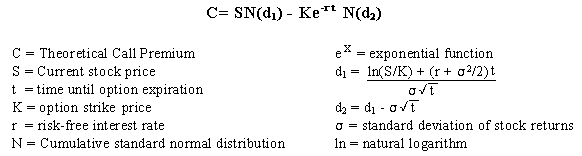

In [ ]:
def norm_cdf(x):
  return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

In [ ]:
## Plotting Volatility Smirk
def convert_iv_to_numeric(df, iv_col='IV'):
    df[iv_col] = (df[iv_col]
                  .astype(str)
                  .str.replace('%', '')
                  .astype(float))
    return df

def bs_call_price(S, K, T, r, sigma, q=0.0):
    if T <= 0:
        return max(0.0, S * math.exp(-q*T) - K * math.exp(-r*T))
    d1 = (math.log(S/K) + (r - q + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    return S * math.exp(-q*T) * norm_cdf(d1) - K * math.exp(-r*T) * norm_cdf(d2)

def bs_put_price(S, K, T, r, sigma, q=0.0):
    if T <= 0:
        return max(0.0, K * math.exp(-r*T) - S * math.exp(-q*T))
    d1 = (math.log(S/K) + (r - q + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    return K * math.exp(-r*T) * norm_cdf(-d2) - S * math.exp(-q*T) * norm_cdf(-d1)

def implied_vol(option_type, price, S, K, T, r=0.01, q=0.0, tol=1e-6, max_iter=100):
    # Select pricing function
    price_func = bs_call_price if option_type.upper() == 'C' else bs_put_price
    low, high = 1e-8, 5.0  # vol range 0% to 500%
    # Check if target price is in range; if not, return None
    if price < price_func(S, K, T, r, low, q) or price > price_func(S, K, T, r, high, q):
        return None
    for _ in range(max_iter):
        mid = 0.5 * (low + high)
        mid_price = price_func(S, K, T, r, mid, q)
        if abs(mid_price - price) < tol:
            return mid
        if mid_price < price:
            low = mid
        else:
            high = mid
    return mid

After defining functions, we calculate IV and compare their respective values against the provided IV (C_IV and P_IV).

In [ ]:
# For each option, calculate the mid price and then compute IV from our own function.
# We then compare our calculated IV with the provided IV (C_IV and P_IV).
calc_call_iv = []
calc_put_iv = []

for idx, row in df.iterrows():
    S = row['UNDERLYING_LAST']
    K = row['STRIKE']
    T = row['DTE'] / 252.0  # use trading year (252 days)
    # Calculate mid prices for calls and puts
    c_mid = 0.5 * (row['C_BID'] + row['C_ASK'])
    p_mid = 0.5 * (row['P_BID'] + row['P_ASK'])

    # Calculate IV for call and put using our Black-Scholes solver
    call_iv_calc = implied_vol('C', c_mid, S, K, T, r=0.01, q=0.0) if c_mid > 0 else np.nan
    put_iv_calc = implied_vol('P', p_mid, S, K, T, r=0.01, q=0.0) if p_mid > 0 else np.nan

    calc_call_iv.append(call_iv_calc)
    calc_put_iv.append(put_iv_calc)

# Add our calculated IVs to the DataFrame
df['calc_C_IV'] = calc_call_iv
df['calc_P_IV'] = calc_put_iv

# (Optional) Compare with provided IVs by checking differences
df['diff_call_IV'] = df['C_IV'] - df['calc_C_IV']
df['diff_put_IV'] = df['P_IV'] - df['calc_P_IV']
print("Summary of differences (provided - calculated):")
print(df[['diff_call_IV','diff_put_IV']].describe())
